<a href="https://colab.research.google.com/github/anamkhan315/test2/blob/main/whale_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/whales'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

from tensorflow.keras import regularizers

In [ ]:
FW_dir = [ r'/content/drive/MyDrive/whales/FW']

GW_dirs = [r'/content/drive/MyDrive/whales/GW']

HBW_dirs = [r'/content/drive/MyDrive/whales/HBW']

SRW_dirs = [r'/content/drive/MyDrive/whales/SRW']

filepaths = []
labels = []
dict_lists = [FW_dir, GW_dirs, HBW_dirs, SRW_dirs]
class_labels = ['fin ', 'gray', 'humpback', 'southernright']

In [ ]:
for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
WHALE_data = pd.concat([Fseries, Lseries], axis=1)
WHALE_df = pd.DataFrame(WHALE_data)
cases_count= WHALE_df["labels"].value_counts()
print(WHALE_df.head())
print(WHALE_df["labels"].value_counts())


                                           filepaths labels
0  /content/drive/MyDrive/whales/FW/PelagosIm3_FW...   fin 
1  /content/drive/MyDrive/whales/FW/PelagosIm2_FW...   fin 
2  /content/drive/MyDrive/whales/FW/PelagosIm2_FW...   fin 
3  /content/drive/MyDrive/whales/FW/PelagosIm2_FW...   fin 
4  /content/drive/MyDrive/whales/FW/PelagosIm2_FW...   fin 
labels
gray             79
southernright    71
humpback         56
fin              34
Name: count, dtype: int64


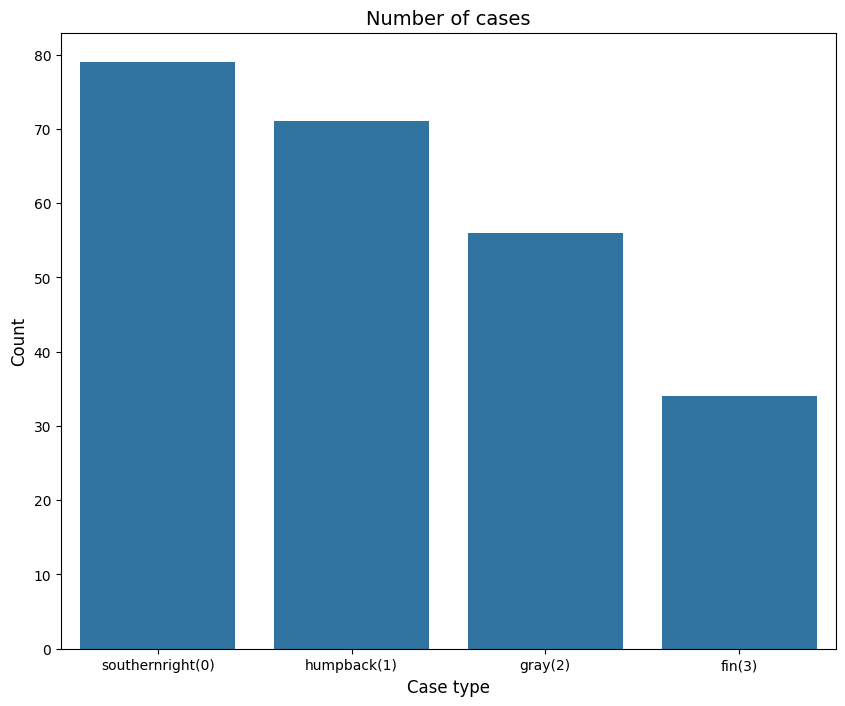

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['southernright(0)','humpback(1)', 'gray(2)', 'fin(3)'])
plt.show()

In [ ]:
train_images, test_images = train_test_split(WHALE_df, test_size=0.3, random_state=42)
test_set, val_set = train_test_split(test_images, test_size=0.5, random_state=42)

In [ ]:
print(test_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(36, 2)
(72, 2)
(36, 2)
(168, 2)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train = train_datagen.flow_from_dataframe(dataframe= train_images,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=8,
                                      shuffle= True
                                     )
image_gen = ImageDataGenerator(rescale = 1./255)
test = image_gen.flow_from_dataframe(dataframe= test_set,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=8,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=8,
                                    shuffle= True
                                   )

Found 168 validated image filenames belonging to 4 classes.
Found 36 validated image filenames belonging to 4 classes.
Found 36 validated image filenames belonging to 4 classes.


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['fin ', 'gray', 'humpback', 'southernright']


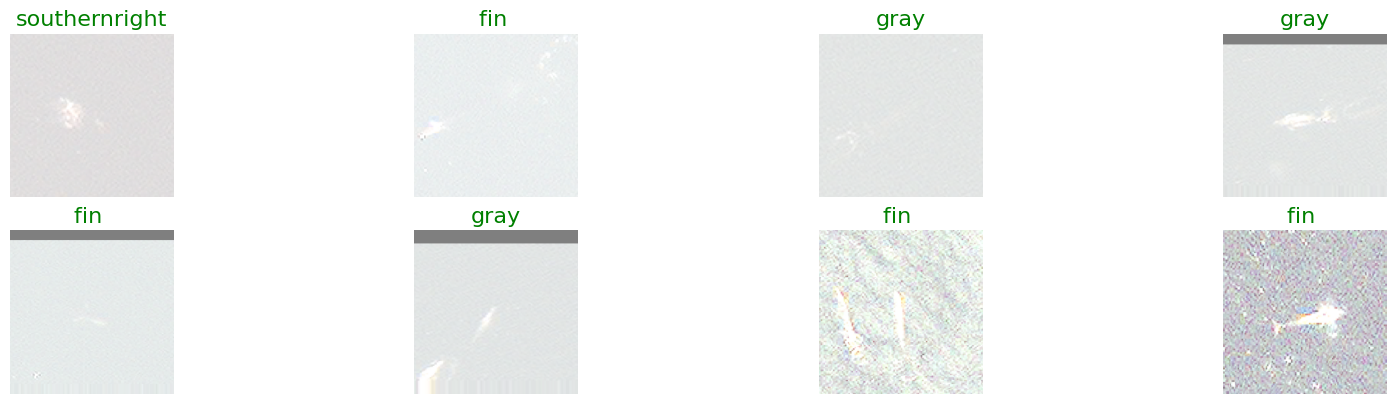

In [ ]:
def show_WHALE_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<32:
        r=length
    else:
        r=32
    for i in range(r):
        plt.subplot(8,4,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_WHALE_images(train)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(244,244, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 79, 79, 128)       24704     
                                                                 
 batch_normalization (Batch  (None, 79, 79, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 79, 79, 256)       819456    
                                                                 
 batch_normalization_1 (Bat  (None, 79, 79, 256)       1024      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 256)       0         
 D)                                                              
                                                        

In [ ]:
history = model.fit(train, epochs=10, validation_data=val,callbacks=[annealer], verbose=1)

Epoch 1/10
21/21 [==============================] - 86s 4s/step - loss: 2.2018 - accuracy: 0.3929 - val_loss: 1.3977 - val_accuracy: 0.0556 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - 3s 150ms/step - loss: 1.6074 - accuracy: 0.5298 - val_loss: 1.3716 - val_accuracy: 0.1944 - lr: 9.5000e-04
Epoch 3/10
21/21 [==============================] - 5s 216ms/step - loss: 1.4787 - accuracy: 0.5655 - val_loss: 1.2719 - val_accuracy: 0.5833 - lr: 9.0250e-04
Epoch 4/10
21/21 [==============================] - 3s 149ms/step - loss: 1.3433 - accuracy: 0.6429 - val_loss: 1.2566 - val_accuracy: 0.5833 - lr: 8.5737e-04
Epoch 5/10
21/21 [==============================] - 3s 147ms/step - loss: 1.1734 - accuracy: 0.6548 - val_loss: 1.2516 - val_accuracy: 0.5833 - lr: 8.1451e-04
Epoch 6/10
21/21 [==============================] - 3s 151ms/step - loss: 1.1588 - accuracy: 0.6369 - val_loss: 1.2856 - val_accuracy: 0.3333 - lr: 7.7378e-04
Epoch 7/10
21/21 [==============================] - 

In [ ]:
history1 = model.fit(train, epochs=1, validation_data=val, verbose=1)

21/21 [==============================] - 3s 158ms/step - loss: 0.6249 - accuracy: 0.7976 - val_loss: 0.8408 - val_accuracy: 0.8611


In [ ]:
model.evaluate(test, verbose=1)

5/5 [==============================] - 11s 3s/step - loss: 1.3001 - accuracy: 0.7222


[1.300057291984558, 0.7222222089767456]

In [ ]:
model.save("WHALE-CLASSIFICATION.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

5/5 [==============================] - 1s 59ms/step


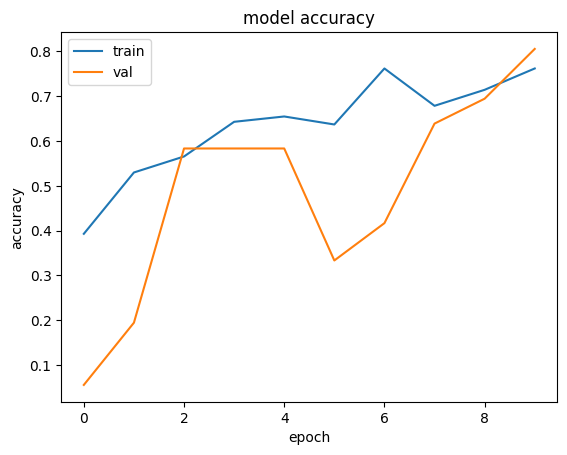

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

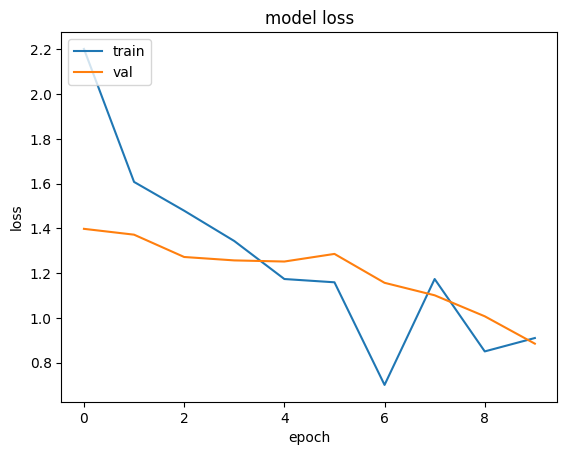

In [ ]:
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_set.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

               precision    recall  f1-score   support

         fin        0.00      0.00      0.00         8
         gray       0.73      1.00      0.85        11
     humpback       0.67      1.00      0.80         6
southernright       0.75      0.82      0.78        11

     accuracy                           0.72        36
    macro avg       0.54      0.70      0.61        36
 weighted avg       0.56      0.72      0.63        36

Accuracy of the Model: 72.2%


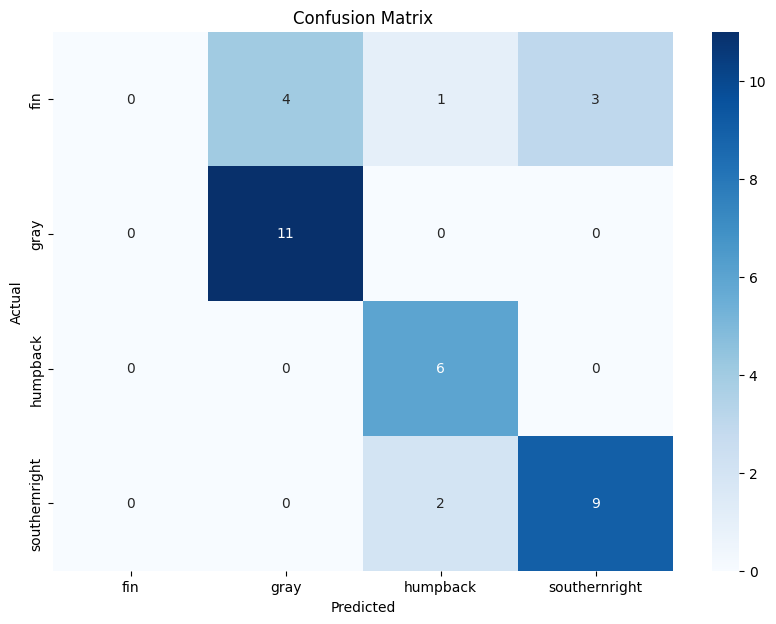

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['fin', 'gray', 'humpback', 'southernright']


cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()